<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done.


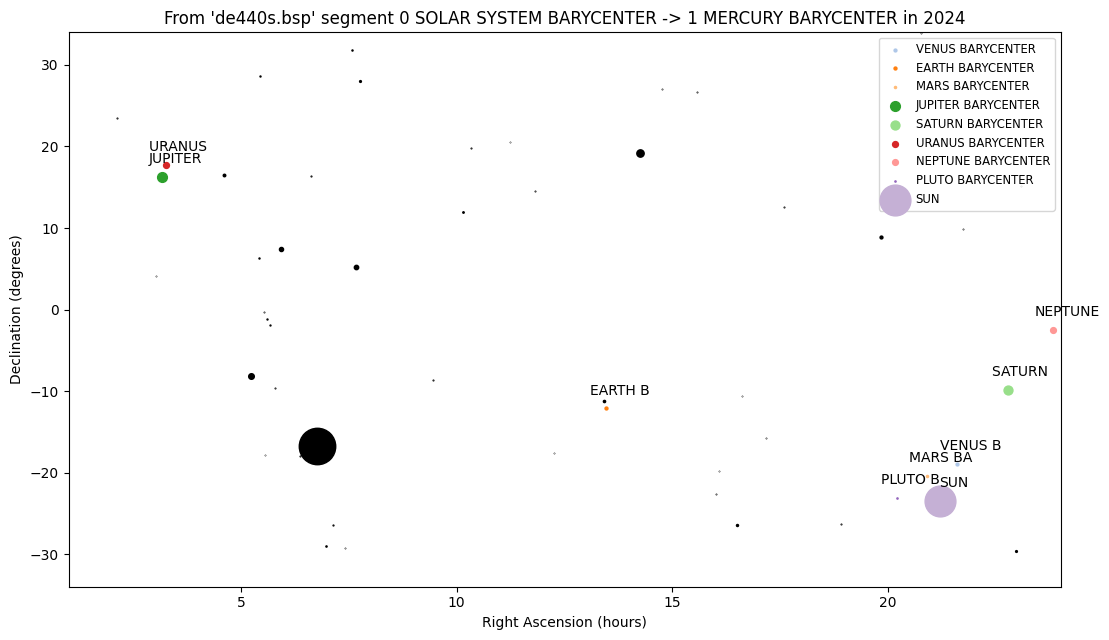

In [7]:
"""This notebook creates a GIF file of the nightsky from the planet Mercury with the 100 brightest stars and the other planets for the current year. """
"""The stars are scaled by the magnitude of their brightness. The GIF file is saved to the notebook's Files folder and the user's file download destination folder."""
"""Precomputing the observations and then plotting."""

"""Install the required packages."""
%pip install skyfield
%pip install matplotlib
%pip install IPython
from google.colab import files
from skyfield.api import load, Star
from skyfield.data import hipparcos
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation',html='jshtml')
import matplotlib.animation as animation
from datetime import datetime

"""Get the current date and time to create a unique file name for the GIF file."""
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
current_year = datetime.now().strftime("%Y")

""" Load star data and get the 100 brightest stars"""
with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)
bright_stars = df.sort_values('magnitude').head(100)

"""Load planetary ephemeris and get the current year"""
planets = load('de440s.bsp')
years = [int(current_year)]

"""Create a figure object"""
fig, ax = plt.subplots(figsize=(12.8,7.2))

"""Create planet names and colors"""
planet_names = ['MERCURY BARYCENTER', 'VENUS BARYCENTER', 'EARTH BARYCENTER', 'MARS BARYCENTER', 'JUPITER BARYCENTER', 'SATURN BARYCENTER', 'URANUS BARYCENTER', 'NEPTUNE BARYCENTER', 'PLUTO BARYCENTER', 'SUN']
planet_colors = matplotlib.colormaps['tab20'].colors[:len(planet_names)]

"""Define a dictionary for solar system object radii in meters"""
planet_radii = {
    'MERCURY BARYCENTER': 2439.7e3,
    'VENUS BARYCENTER': 6051.8e3,
    'EARTH BARYCENTER': 6371e3,
    'MARS BARYCENTER': 3389.5e3,
    'JUPITER BARYCENTER': 69911e3,
    'SATURN BARYCENTER': 58232e3,
    'URANUS BARYCENTER': 25362e3,
    'NEPTUNE BARYCENTER': 24622e3,
    'PLUTO BARYCENTER': 1188.3e3,
    'SUN': 6.9634e8
  }

"""Number of sols per year on each planet"""
sols_per_planet_year = [88, 225, 365, 687, 4333, 10759, 30687, 60190, 90520, 365]

"""Get the current time"""
ts = load.timescale()
t = ts.now()

def get_planet_observation(planet, year, ts):
    """Get the daily nightsky observations for an observer on given planet and year.

    Args:
        planet (int): The index of the planet to observe.
        year (int): The year to observe.
        ts (Time): The timescale object.

    Returns:
        list: A list of observations for the given planet and year.
    """
    days = sols_per_planet_year[planet]
    planet_obs_from = planets[planet_names[planet]]
    all_obs = []

    for day in range(1, days + 1):
        t_day = ts.utc(year, 1, day)
        for j in range(len(planet_names)):
            if j != planet:
                planet_to_observe = planets[planet_names[j]]
                observation = planet_obs_from.at(t_day).observe(planet_to_observe).apparent()
                ra, dec, _ = observation.radec()
                obs_list = [year, day, j, ra.hours, dec.degrees]
                all_obs.append(obs_list)

    return all_obs

def compute_star_positions(year):
    """Function to compute the star positions for a given year

    Args:
        year (int): The year to compute the star positions.

    Returns:
        list: The right ascension and declination for star positions for the given year.
    """
    with load.open(hipparcos.URL) as f:
        df = hipparcos.load_dataframe(f)
        df = df[df['magnitude'] <= 3.0]

    star_positions = []
    for _, star_row in df.iterrows():
        star = Star.from_dataframe(star_row)
        astrometric = planets['earth'].at(ts.utc(year, 1, 1)).observe(star)
        ra, dec, _ = astrometric.radec()
        star_positions.append((ra.hours, dec.degrees, star_row['magnitude']))

    return star_positions

def update_plot(frame, all_obs, ax, planet_colors, days, planet_obs_from):
    """Update the nightsky plot for each frame.

    Args:
        frame (int): The frame number.
        all_obs (list): The list of all planet observations.
        ax (Axes): The axis object.
        planet_colors (string): The colors of the planets.
        days (int): The number of days in a year.
        planet_obs_from (int): The index of the planet to observe.
    """
    ax.clear()
    ax.set_ylim(-34, 34)
    ax.set_xlim(1, 24)
    ax.set_xlabel('Right Ascension (hours)')
    ax.set_ylabel('Declination (degrees)')

    year = all_obs[frame // days][0]
    day = frame % days
    """List to store planets that have been plotted"""
    plotted_planets = []  

    for observation in all_obs:
        if observation[0] == year and observation[1] == day:
            _, _, planet_index, ra, dec = observation
            planet_radius = planet_radii[planet_names[planet_index]]
            """Adust the scaling factor based on your preference"""
            scaled_size = 4.5 * (planet_radius / planet_radii['EARTH BARYCENTER']) 
            planet_marker = ax.scatter(ra, dec, s=scaled_size, color=planet_colors[planet_index])
            plotted_planets.append((planet_marker, planet_names[planet_index][:20]))
            ax.annotate(planet_names[planet_index][:7], (ra, dec), textcoords="offset points", xytext=(10, 10), ha='center')

    """Scale stars based on their magnitudes"""
    for _, star_row in bright_stars.iterrows():
        star = Star.from_dataframe(star_row)
        astrometric = planet_obs_from.at(t).observe(star)
        ra, dec, _ = astrometric.radec()

        """Compute scaling factor based on magnitude"""
        magnitude = star_row['magnitude']
        """Base size for stars (you can adjust this value)"""
        base_size = 25 
        """Inverse proportionality"""
        scaled_size = base_size * 10 ** (-magnitude) 

        ax.scatter(ra.hours, dec.degrees, color='black', s=scaled_size)

    ax.set_title(f'From {planet_obs_from} in {years[0]}')

    """Create legend for the plotted planets"""
    if plotted_planets:
        markers, labels = zip(*plotted_planets)
        ax.legend(markers, labels, loc='upper right', fontsize='small')


def plot_sky(planet_observer):
    """Plot the nightsky for the given planet observer.

    Args:
        planet_observer (int): Index of the planet observer.
    """
    days = sols_per_planet_year[planet_observer]
    planet_name = planet_names[planet_observer]
    planet_obs_from = planets[planet_name]

    all_obs = []
    for year in years:
        all_obs.extend(get_planet_observation(planet_observer, year, ts))

    ani = animation.FuncAnimation(fig, update_plot, frames=range(1, len(years) * days), fargs=(all_obs, ax, planet_colors, days, planet_obs_from), repeat=True, interval=200)
    ani.save('astroselfie-precompute.gif')
    files.download('astroselfie-precompute.gif')

plot_sky(0)
print("Done.")